In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats

In [2]:
df_clustering = pd.read_parquet('output/dataset_seleccionado_para_clustering.parquet')
print(f"\nDataset cargado: {df_clustering.shape[0]:,} hogares × {df_clustering.shape[1]} variables")



Dataset cargado: 57,366 hogares × 168 variables


In [3]:
print("\n" + "-"*80)
print("ANÁLISIS DE ESCALAS DE VARIABLES")
print("-"*80)

# Analizar rangos
print("\nAnálisis de rangos de variables:\n")

rangos_analisis = []
for col in df_clustering.columns:
    rango = df_clustering[col].max() - df_clustering[col].min()
    mean = df_clustering[col].mean()
    std = df_clustering[col].std()
    
    rangos_analisis.append({
        'Variable': col,
        'Min': df_clustering[col].min(),
        'Max': df_clustering[col].max(),
        'Rango': rango,
        'Mean': mean,
        'Std': std
    })

df_rangos = pd.DataFrame(rangos_analisis).sort_values('Rango', ascending=False)

print("Variables con mayor rango (escala):")
print("-"*80)
display(df_rangos.head(15))

print("\nVariables con menor rango:")
print("-"*80)
display(df_rangos.tail(10))


--------------------------------------------------------------------------------
ANÁLISIS DE ESCALAS DE VARIABLES
--------------------------------------------------------------------------------

Análisis de rangos de variables:

Variables con mayor rango (escala):
--------------------------------------------------------------------------------


,Variable,Min,Max,Rango,Mean,Std
108,r44105,0.0,25000.00,25000.00,2.725900,172.515154
22,ingfa,0.0,8420.00,8420.00,774.695531,690.674494
25,ingre,0.0,6620.00,6620.00,190.893050,329.300853
0,ingreso_independientes,0.0,6200.00,6200.00,40.070852,196.794503
110,r44107,0.0,5000.00,5000.00,0.671783,33.488258
19,imeds,-1.0,4333.33,4334.33,119.844366,253.272347
158,gasto_total_estimado,0.0,3797.50,3797.50,254.492822,275.431836
24,ingpe,0.0,3500.00,3500.00,212.664994,194.797514
14,gmvi,0.0,2822.50,2822.50,105.613996,122.244871
15,gmem,0.0,2704.00,2704.00,75.711320,148.486810



Variables con menor rango:
--------------------------------------------------------------------------------


,Variable,Min,Max,Rango,Mean,Std
144,r619_8,1.0,2.000000,1.000000,1.995485,0.067042
143,r619_7,1.0,2.000000,1.000000,1.990273,0.098146
139,r619_3,1.0,2.000000,1.000000,1.996095,0.062366
142,r619_6,1.0,2.000000,1.000000,1.992504,0.086254
141,r619_5,1.0,2.000000,1.000000,1.993951,0.077540
140,r619_4,1.0,2.000000,1.000000,1.988146,0.108228
167,tiene_ocupado,0.0,1.000000,1.000000,0.936740,0.243433
154,tiene_remesas,0.0,1.000000,1.000000,0.090611,0.287058
156,dependencia_remesas,0.0,0.999339,0.999339,0.040245,0.163214
162,proporcion_enfermos,0.0,0.875000,0.875000,0.129170,0.193281


In [4]:
print("\n" + "-"*80)
print("DETECCIÓN DE OUTLIERS")
print("-"*80)

print("\nDetectando outliers (método Z-score)...")

# Detectar outliers por variable
outliers_por_variable = []
n_outliers_total = 0

for col in df_clustering.columns:
    # Z-score
    z_scores = np.abs(stats.zscore(df_clustering[col]))
    
    # Outliers: |z| > 3
    n_outliers = (z_scores > 3).sum()
    pct_outliers = (n_outliers / len(df_clustering)) * 100
    
    if n_outliers > 0:
        outliers_por_variable.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Pct_Outliers': pct_outliers
        })
        n_outliers_total += n_outliers

df_outliers = pd.DataFrame(outliers_por_variable).sort_values('Pct_Outliers', ascending=False)

print(f"\nResumen de outliers:")
print(f"   Variables con outliers: {len(df_outliers)}")
print(f"   Total de outliers detectados: {n_outliers_total:,}")

if len(df_outliers) > 0:
    print(f"\nTop 20 variables con más outliers:")
    print("-"*80)
    display(df_outliers.head(20))

# Estrategia: Winsorización + RobustScaler
print(f"\nESTRATEGIA A APLICAR: Winsorización + RobustScaler")
print("-"*80)

USAR_WINSORIZATION = True
USAR_ROBUST_SCALER = True

if USAR_WINSORIZATION:
    print("\nAplicando winsorización (percentiles 1-99)...")
    
    df_clustering_winsorized = df_clustering.copy()
    n_valores_modificados = 0
    
    for col in df_clustering.columns:
        p1 = df_clustering[col].quantile(0.01)
        p99 = df_clustering[col].quantile(0.99)
        
        # Contar cuántos se modificarán
        n_modificados = ((df_clustering[col] < p1) | (df_clustering[col] > p99)).sum()
        n_valores_modificados += n_modificados
        
        # Winsorizar
        df_clustering_winsorized[col] = df_clustering[col].clip(lower=p1, upper=p99)
    
    print(f"  Winsorización completada")
    print(f"  Valores modificados: {n_valores_modificados:,} ({(n_valores_modificados / (df_clustering.shape[0] * df_clustering.shape[1]) * 100):.2f}%)")
    
    # Usar dataset winsorizado
    df_to_scale = df_clustering_winsorized
else:
    df_to_scale = df_clustering


--------------------------------------------------------------------------------
DETECCIÓN DE OUTLIERS
--------------------------------------------------------------------------------

Detectando outliers (método Z-score)...

Resumen de outliers:
   Variables con outliers: 117
   Total de outliers detectados: 121,988

Top 20 variables con más outliers:
--------------------------------------------------------------------------------


,Variable,N_Outliers,Pct_Outliers
28,r212,5710,9.953631
84,r605,5219,9.097723
105,tiene_remesas,5198,9.061116
85,r607,4838,8.433567
83,r512,4101,7.148834
116,tiene_ocupado,3629,6.326047
2,viv,3297,5.747307
6,d412b,3041,5.301049
29,r213,3011,5.248754
86,r608,3008,5.243524



ESTRATEGIA A APLICAR: Winsorización + RobustScaler
--------------------------------------------------------------------------------

Aplicando winsorización (percentiles 1-99)...
  Winsorización completada
  Valores modificados: 41,013 (0.43%)


In [5]:
print("\n" + "-"*80)
print("ESTANDARIZACIÓN")
print("-"*80)

if USAR_ROBUST_SCALER:
    print("\nAplicando RobustScaler (robusto a outliers)...")
    scaler = RobustScaler()
    scaler_name = "RobustScaler"
else:
    print("\nAplicando StandardScaler...")
    scaler = StandardScaler()
    scaler_name = "StandardScaler"

# Guardar nombres de columnas
column_names = df_to_scale.columns.tolist()

# Escalar
X_scaled = scaler.fit_transform(df_to_scale)

# Convertir de vuelta a DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=column_names, index=df_to_scale.index)

print(f"  {scaler_name} aplicado")
print(f"  Shape: {df_scaled.shape[0]:,} × {df_scaled.shape[1]}")

# Verificar que la estandarización funcionó
print(f"\nVerificación de estandarización:")

if USAR_ROBUST_SCALER:
    print(f"   Mediana de variables (debe estar cerca de 0):")
    print(f"      Promedio de medianas: {df_scaled.median().mean():.6f}")
    print(f"   IQR promedio (debe estar cerca de 1):")
    # IQR = Q3 - Q1
    iqrs = df_scaled.quantile(0.75) - df_scaled.quantile(0.25)
    print(f"      Promedio de IQRs: {iqrs.mean():.6f}")


--------------------------------------------------------------------------------
ESTANDARIZACIÓN
--------------------------------------------------------------------------------

Aplicando RobustScaler (robusto a outliers)...
  RobustScaler aplicado
  Shape: 57,366 × 168

Verificación de estandarización:
   Mediana de variables (debe estar cerca de 0):
      Promedio de medianas: 0.000000
   IQR promedio (debe estar cerca de 1):
      Promedio de IQRs: 0.482143


In [6]:
print("\n" + "-"*80)
print("VERIFICACIONES FINALES")
print("-"*80)

# 1. Sin faltantes
n_faltantes = df_scaled.isnull().sum().sum()
print(f"\nValores faltantes:")
print(f" Total: {n_faltantes}")

# 2. Sin infinitos
n_infinitos = np.isinf(df_scaled.values).sum()
print(f"\nValores infinitos:")
print(f" Total: {n_infinitos}")

# 3. Todas numéricas
tipos = df_scaled.dtypes.value_counts()
print(f"\nTipos de datos:")
for tipo, count in tipos.items():
    print(f"   {tipo}: {count} variables")

solo_numericas = all(dtype in ['float64', 'int64'] for dtype in df_scaled.dtypes)
print(f"  Solo numéricas: {solo_numericas}")

# 4. Dimensiones razonables
ratio = df_scaled.shape[0] / df_scaled.shape[1]
print(f"\nRatio hogares/variables:")
print(f"   {ratio:.1f}:1")
print(f"  {'Ratio adecuado' if ratio > 100 else 'Ratio bajo'}")

# 5. Balance de categorías
print(f"\nBalance de variables:")

categorias_finales = {
    'Económicas': 20,
    'Demográficas': 6,
    'Empleo': 8,
    'Educación': 9,
    'Salud': 18,
    'Gastos': 25,
    'Vivienda': 25,
    'Servicios': 9,
    'Seguridad': 18,
    'Índices': 7,
    'Otras': 23
}

for cat, count in categorias_finales.items():
    pct = (count / df_scaled.shape[1]) * 100
    print(f"   {cat:15s}: {count:3d} ({pct:5.1f}%)")

gastos_vivienda = (50 / df_scaled.shape[1]) * 100
print(f"\n Gastos+Vivienda: {gastos_vivienda:.1f}%")
print(f"   {'Balanceado' if gastos_vivienda < 35 else 'Revisar balance'}")



--------------------------------------------------------------------------------
VERIFICACIONES FINALES
--------------------------------------------------------------------------------

Valores faltantes:
 Total: 0

Valores infinitos:
 Total: 0

Tipos de datos:
   float64: 168 variables
  Solo numéricas: True

Ratio hogares/variables:
   341.5:1
  Ratio adecuado

Balance de variables:
   Económicas     :  20 ( 11.9%)
   Demográficas   :   6 (  3.6%)
   Empleo         :   8 (  4.8%)
   Educación      :   9 (  5.4%)
   Salud          :  18 ( 10.7%)
   Gastos         :  25 ( 14.9%)
   Vivienda       :  25 ( 14.9%)
   Servicios      :   9 (  5.4%)
   Seguridad      :  18 ( 10.7%)
   Índices        :   7 (  4.2%)
   Otras          :  23 ( 13.7%)

 Gastos+Vivienda: 29.8%
   Balanceado



VISUALIZACIÓN DE DISTRIBUCIONES


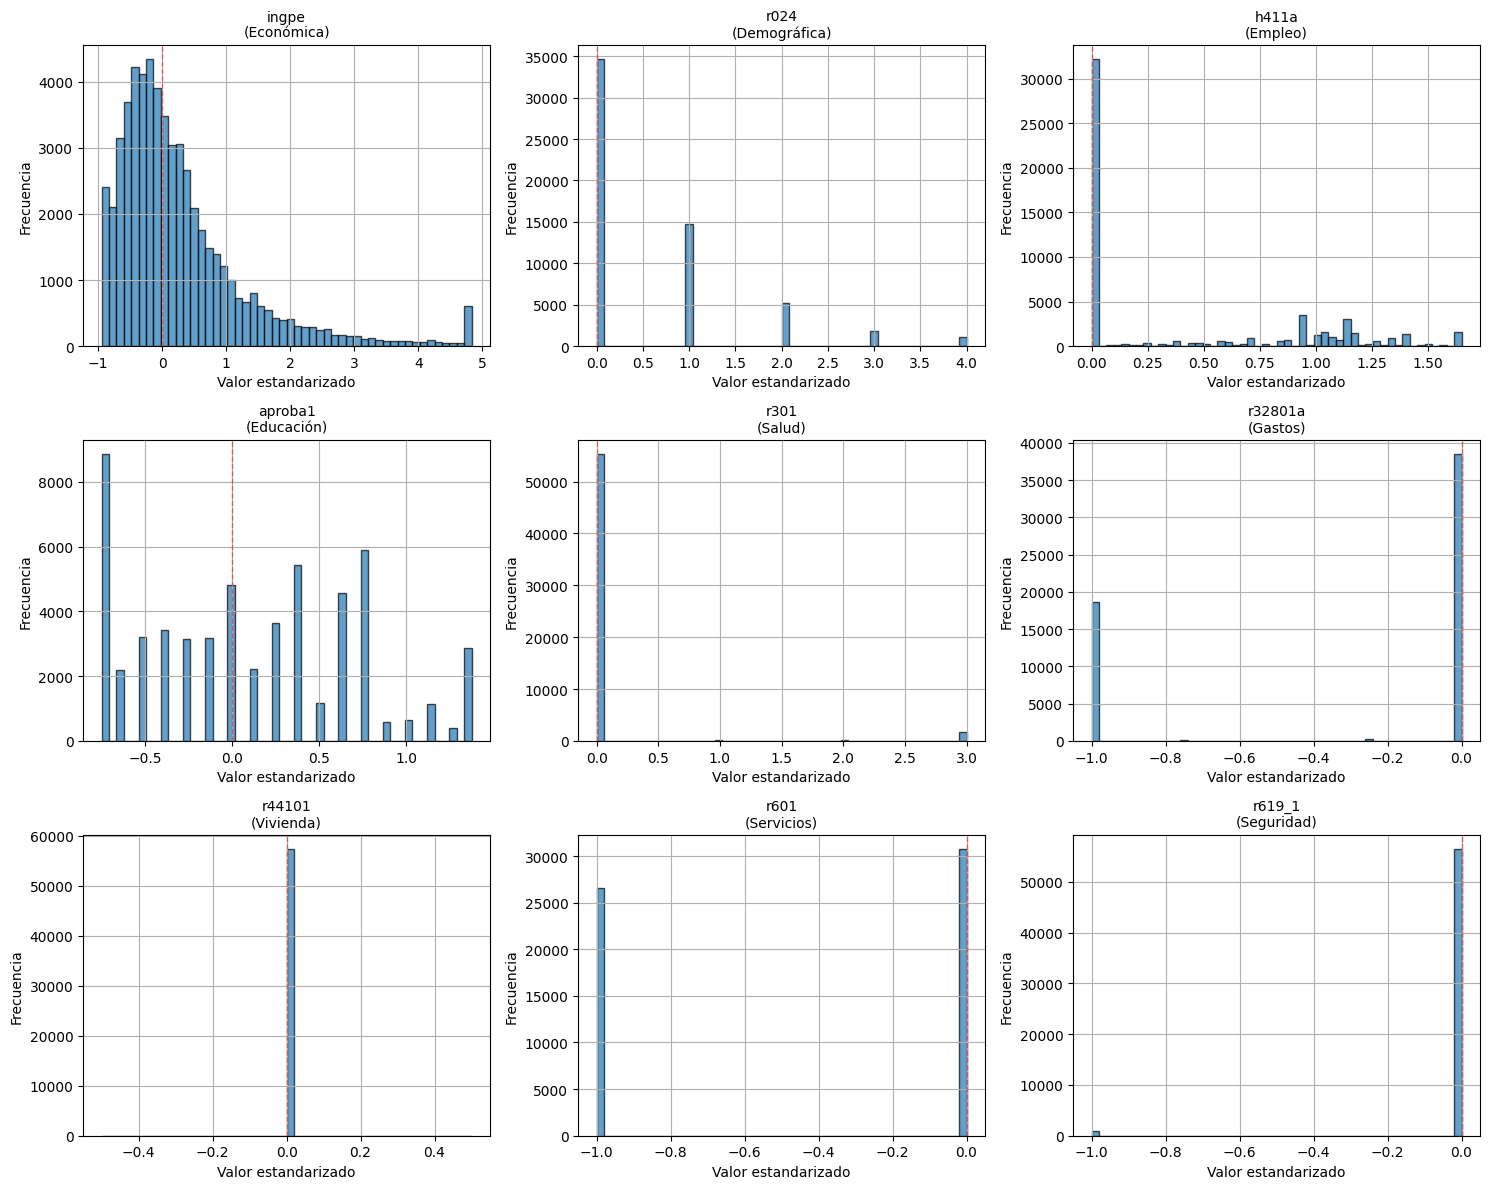

In [7]:

print("\n" + "="*80)
print("VISUALIZACIÓN DE DISTRIBUCIONES")
print("="*80)

vars_visualizar = {
    'ingpe': 'Económica',
    'r024': 'Demográfica',
    'h411a': 'Empleo',
    'aproba1': 'Educación',
    'r301': 'Salud',
    'r32801a': 'Gastos',
    'r44101': 'Vivienda',
    'r601': 'Servicios',
    'r619_1': 'Seguridad'
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (var, categoria) in enumerate(vars_visualizar.items()):
    if var in df_scaled.columns:
        ax = axes[idx]
        
        # Histograma
        df_scaled[var].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'{var}\n({categoria})', fontsize=10)
        ax.set_xlabel('Valor estandarizado')
        ax.set_ylabel('Frecuencia')
        ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()

In [8]:
# Guardar dataset estandarizado
output_path = 'output/dataset_estandarizado_para_clustering.parquet'

df_scaled.to_parquet(output_path, compression='snappy',engine='fastparquet', index=False)
print(f"\n Dataset estandarizado guardado:")
print(f"   {output_path}")
print(f"   {df_scaled.shape[0]:,} hogares × {df_scaled.shape[1]} variables")



 Dataset estandarizado guardado:
   output/dataset_estandarizado_para_clustering.parquet
   57,366 hogares × 168 variables
